The previous section dealt with parabolic equations like the heat equation, in which information traveled at infinite speed. In contrast, in a hyperbolic system, there is a fixed maximum speed at which information can travel. The simplest hyperbolic equation is the transport equation:
$$
    u_t + a u_x = 0,\\
    u(x, 0) = g(x)
$$
where $a$ is a constant (positive or negative) and $g$ specifies the initial conditions.

Using the principles from the last section, we can try to design a second-order in space scheme by using the centered difference approximation to $u_x$:
$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + a \frac{U^n_{j+1} - U^n_{j-1}}{2 \Delta x} = 0,\\
    U^{n+1}_j = \frac{r}{2} U^n_{j-1} + U^n_j - \frac{r}{2} U^n_{j+1},
$$
where $r = a \Delta t/\Delta x$. We can code this up quickly with $a = 1$, periodic boundary conditions on the interval $[0, 1]$, and some initial conditions:

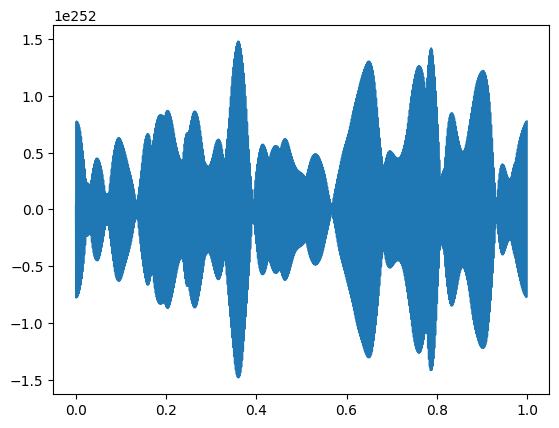

In [29]:
import numpy as np
import matplotlib.pyplot as plt

T = 1 # final time
J = 2000 # J spatial points (not J+1 because we have periodic BCs)
N = 2500 # N+1 time grid points
dx = 1/J
dt = 1/N
r = dt/dx
xvals = np.linspace(0, 1, num=J, endpoint=False)
U = np.sin(xvals*2*np.pi) # initial conditions

for i in range(N):
    U = r/2*np.roll(U, 1) + U - r/2*np.roll(U, -1)

plt.plot(xvals, U)

This is not at all what we had hoped for. The scheme is exhibiting numerical instability. This is even with extremely smooth initial conditions. As an experiment, see what happens for other step sizes. Can you make it stable? What if you change the initial conditions to be only continuous instead of smooth? Or discontinuous?

To see what went wrong, we need a stability analysis. The truncation error of the scheme is $O(\Delta t + \Delta x^2)$, since we use a forward difference to estimate the time derivative and a centered difference for the space derivative. This makes it a first-order scheme, which is acceptable. The coefficients on the right hand side of the scheme sum to $1$ but are not all positive, indicating that an $\ell^\infty$ analysis might be difficult or impossible. We can take the discrete Fourier transform of the defining equation to get that
$$
    \hat U^{n+1} = r\hat U^n(e^{-i \xi} -e^{i \xi})/2 + \hat U^n,
$$
and the Fourier symbol is
$$
    \rho(\xi) = 1- i r \sin(\xi).
$$

Its squared magnitude is $|\rho^2| = 1 + r^2 \sin^2(\xi)$. There is always a value of $\xi$ (or rather, almost all values) for which this is greater than $1$, and so the frequency corresponding to that $\xi$ will blow up. The only way this can be stable is if $r$ goes to $0$ sufficiently quickly as $\Delta t$ and $\Delta x$ go to $0$. We found that the necessary and sufficient condition for $\ell^2$ stability is $|\rho(\xi)| \leq 1 + c \Delta t$ for some constant $c$. We know $|\rho^2| \leq 1 + r^2$, and a Taylor series tells us $\sqrt{1+r^2} \approx 1+r^2/2$ when $r$ is small enough. In fact, we can show $\sqrt{1+r^2} \leq 1 + r^2/2$ for all $r$ by squaring both sides and comparing. Thus, for $\ell^2$ stability, we need $r^2 \leq c \Delta t$, which simplifies to $\Delta t/\Delta x^2 \leq c$ for some constant $c$. The step size $\Delta t = O(\Delta x^2)$ is extremely small, and as $\Delta t$ and $\Delta x$ go to $0$, the domain of dependance becomes the entire domain. This is unnecessary for a hyperbolic scheme, where we know the true domain of dependence is finite.

In order to design a better scheme, we need to know more about the PDE. It turns out that this one is very simple, but the ideas presented extend to a broad class of hyperbolic PDEs which do not have simple solutions.

If we set $f(s) = u(x_0 + a s,t_0 + s)$ then 
$$
    df/ds = u_x(x_0+as, t_0+s)(a) + u_t(x_0+as,t_0+s) = 0.
$$
This tells us that $f$ is constant, and $f(s) = f(0)$. So $u(x_0 + a s,t_0 + s) = u(x_0, t_0)$. Finally, we can use $s = t_0$ to see that
$$
    u(x_0, t_0) = u(x_0 - a t_0, t_0 - t_0) = g(x_0 - a t_0).
$$
Thus, we have found the general solution $u(x, t) = g(x - at)$. 

All that the linear transport equation does is take the initial conditions and shift them over time, with a speed of $a$. For this reason, we can say that information travels with a finite speed, namely $a$. In the heat equation, we saw that a scheme which did not take into account global information did very poorly. In contrast, we expect that a scheme which takes into account only local information can be just fine, because all the information needed to propagate the solution forward is local.

With knowledge of the general solution in hand, the linear transport equation becomes trivial to solve numerically, but it will be a good testbed for schemes which may be extended to more difficult problems. We will find out that many schemes do not perform nearly as well as we would have hoped, especially if the initial conditions are not particularly nice.

One final thing to consider is where the information comes from. From the general solution $u(x, t) = g(x-at)$, we see that if we want to know the solution at a point $x_0$ slightly in the future, $u(x_0, 0.1) = u(x_0-0.1 a, 0)$. Thus, the solution at $x_0$ depends on the value of $u$ at $t=0$ slightly to the left of $x_0$ if $a$ is positive, or slightly to the right of $x_0$ if $a$ is negative. This motivates the definition of the *upwind* direction: the direction from which information comes from. If $a > 0$, the upwind direction is to the left (negative), and if $a < 0$, the upwind direction is to the right (positive).

We also see that the solution at $x_0$ at some time in the future is completely independent of what happens downwind of $x_0$. Thus, our schemes should reflect this physical reality. Let's design our first stable scheme, the *upwind scheme*.

We will use the discrete derivative approximation to $(u_x)^n_j$ which involves the gridpoints upwind of $x_j$. If $a > 0$, the wind is blowing to the right and the upwind points will be $x_{j-1}$ and $x_j$. If $a < 0$, the upwind points are $x_j$ and $x_{j+1}$. Thus, the upwind approximation to the derivative is
$$
    \begin{cases}
        \frac{U^n_j - U^n_{j-1}}{\Delta x}, \text{ if } a \geq 0, \\
        \frac{U^n_{j+1} - U^n_J}{\Delta x}, \text{ if } a < 0.
    \end{cases}
$$

In this problem, the wind speed and direction are constant, but this is not always the case. If we have variable wind direction, it can be convenient to write the approximation to $a u_x$ in the following way:
$$
    [a^+(U^n_j - U^n_{j-1})  + a^- (U^n_{j+1} - U^n_J)]/\Delta x,
$$
where $a^+ = \max(a, 0)$ is $a$ if $a \geq 0$ and is $0$ otherwise, and $a^- = \min(a, 0)$ is $a$ if $a \leq 0$ and is $0$ otherwise.

From this, we can write the upwind scheme as
$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + [a^+(U^n_j - U^n_{j-1})  + a^- (U^n_{j+1} - U^n_J)]/\Delta x = 0.
$$
The truncation error is $O(\Delta t + \Delta x)$, so this is a first-order scheme. Before implementing this, it would be wise to do some stability analysis first. For stability analysis, the notation will be much cleaner if we assume that $a \geq 0$, but the results apply for any $a$. In this case, we set $r = a \Delta t/\Delta x$ and compute
$$
    U^{n+1}_j = (1-r)U^n_j + r U^n_{j-1}.
$$

The coefficients on the right sum to $1$, and their absolute values sum to $1$ as long as $r \geq 0$ and $1-r \geq 0$, which tells us $0 \leq r \leq 1$. Since we assumed $a \geq 0$, the first inequality always holds. Thus, we have $\ell^\infty$ stability so long as $r = a \Delta t/\Delta x \leq 1$. If $a < 0$ and we used $U^n_{j+1} - U^n_J$ in the derivative approximation, we would get the condition that $a \Delta t/\Delta x \geq -1$ (remembering that $a$ is negative). This is a good simple exercise. Thus, the upwind scheme is stable in $\ell^\infty$ if $|a| \Delta t/\Delta x = |r| \leq 1.$ This is known as the CFL (Courant-Friedrichs-Lewy) condition and is ubiquitous in the numerical analysis of hyperbolic PDEs. Often, the number $|a| \Delta t/\Delta x$ is referred to as the CFL number of a scheme. Now let's code it with periodic boundary conditions as before. This time, we'll add some sliders so that we can watch it evolve over time or see dependence on parameters.

In [75]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def upwind(dx, dt, T):
    J = int(1/dx) # Find the right number of gridpoints
    N = int(T/dt) # This must be an integer
    a = 1
    dx = 1/J # Correct the values of dx, dt
    dt = T/N
    r = a*dt/dx
    xvals = np.linspace(0, 1, num=J, endpoint=False)

    U = np.sin(xvals*2*np.pi)  # initial conditions
    for i in range(N):
        U = (1-r)*U + r*np.roll(U, 1)

    # plot    
    plt.ylim(-1.1, 1.1)
    plt.plot(xvals, U)
    plt.show()

# interact 
interact(upwind, dt=widgets.FloatSlider(value=1/150,
                                        min=1/1000,
                                        max=1/50,
                                        step=0.001,
                                        readout_format='.3f'),
                 dx=widgets.FloatSlider(value=1/100,
                                        min=1/1000,
                                        max=1/50,
                                        step=1/1000,
                                        readout_format='.3f'),
                  T=widgets.FloatSlider(value=1.1,
                                        min=.1,
                                        max=10,
                                        step=.01,
                                        readout_format='.2f'))
               

interactive(children=(FloatSlider(value=0.01, description='dx', max=0.02, min=0.001, readout_format='.3f', ste…

<function __main__.upwind(dx, dt, T)>

The interact feature requires a live Jupyter kernel to work. If you are viewing this on a static webpage, such as GitHub, you can view the interactive plot by copying the code into a 